In [1]:
import sys
from copy import deepcopy
from collections import OrderedDict
from collections import defaultdict

import scipy.stats
import pandas as pd
import numpy as np

import pylogit as pl

sys.path.insert(0, '../src/')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/processed/model_ready_car_data.csv")

# Create the new model specification

#### Create variables for the new model

I need 3 things:
1. Interactions for the separate categories of body type with respect to all variables (except maybe luggage space)
2. Interactions for the separate categories of fuel type with respect to:
   1. price
   2. range
   3. top speed
   4. pollution
   5. operating costs
3. Piecewise linear specifications of:
   1. price
   2. range
   3. acceleration
   4. top speed
   5. pollution
   6. operating costs
4. <strike>Change specification of price to [x, ln(x)]</strike>
   1. (Not done to reduce model complexity.)

In [3]:
def create_specification_dict(list_of_cols_and_names):
    # Create interaction variables for the various body types
    body_names = ['sports_utility_vehicle',
                  'sports_car',
                  'station_wagon',
                  'truck',
                  'van']

    non_body_or_fuel_vars = ['price_over_log_income',
                             'price_over_log_income_lte_3',
                             'price_over_log_income_gt_3',
                             'range_over_100',
                             'acceleration_over_10',
                             'top_speed_over_100',
                             'pollution',
                             'vehicle_size_over_10',
                             'tens_of_cents_per_mile']

    body_interactions = defaultdict(lambda : [])

    for body in body_names:
        for interaction_var in non_body_or_fuel_vars:
            new_name = interaction_var + "_for_" + body
            # Store the new variable name
            body_interactions[interaction_var].append(new_name)

    # Create interaction variables for the various fuel types
    fuel_names = ['electric',
                  'compressed_natural_gas',
                  'methanol']

    fuel_interaction_vars = ['price_over_log_income',
                             'price_over_log_income_lte_3',
                             'price_over_log_income_gt_3',
                             'range_over_100',
                             'top_speed_over_100',
                             'pollution',
                             'vehicle_size_over_10',
                             'tens_of_cents_per_mile']

    fuel_interactions = defaultdict(lambda : [])

    for fuel in fuel_names:
        for interaction_var in fuel_interaction_vars:
            new_name = interaction_var + "_for_" + fuel
            # Store the new variable name
            fuel_interactions[interaction_var].append(new_name)
            
    # Create specification and name objects
    spec_dict, name_dict = OrderedDict(), OrderedDict()
            
    for col, display_name in list_of_cols_and_names:
        if col in body_interactions:
            for interaction_col in body_interactions[col]:
                suffix = interaction_col[interaction_col.rfind("for_") + 4:]
                new_display_name = display_name + " ({})".format(suffix)

                if car_df[interaction_col].unique().size == 1:
                    continue

                spec_dict[interaction_col] = 'all_same'
                name_dict[interaction_col] = new_display_name

            for interaction_col in fuel_interactions[col]:
                suffix = interaction_col[interaction_col.rfind("for_") + 4:]
                new_display_name = display_name + "({})".format(suffix)

                if car_df[interaction_col].unique().size == 1:
                    continue

                spec_dict[interaction_col] = 'all_same'
                name_dict[interaction_col] = new_display_name

        spec_dict[col] = 'all_same'
        name_dict[col] = display_name
        
    return spec_dict, name_dict


In [4]:
orig_cols_and_display_names =\
    [('price_over_log_income_lte_3', 'Price over log(income) <= 3'),
     ('price_over_log_income_gt_3', 'Price over log(income) > 3'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
interaction_mnl_spec, interaction_mnl_names =\
    create_specification_dict(orig_cols_and_display_names)

# Try an mnl with body and fuel interactions and piecewise linear price

In [5]:
# Determine the number of index coefficients for the full interaction MNL
num_index_coefs = len(interaction_mnl_names)

# Initialize the full interaction mnl model object
interaction_model =\
    pl.create_choice_model(data=car_df,
                           alt_id_col='alt_id',
                           obs_id_col='obs_id',
                           choice_col='choice',
                           specification=interaction_mnl_spec,
                           model_type='MNL',
                           names=interaction_mnl_names)
    
interaction_model.fit_mle(np.zeros(num_index_coefs))

interaction_model.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -8,338.8486


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.20 seconds.
Final log-likelihood: -7,311.6340


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,572
Method:                                MLE   Df Model:                           82
Date:                     Sun, 10 Jun 2018   Pseudo R-squ.:                   0.123
Time:                             17:49:25   Pseudo R-bar-squ.:               0.113
AIC:                            14,787.268   Log-Likelihood:             -7,311.634
BIC:                            15,315.798   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) <= 3 (sports_utility_vehicle)      0.2328      0.257      0.905      0.366      -0.271       0.737
Price over log(income) <= 3 (sports_car)                 -0.1069      0.253     -0.423      0.673      -0.603       0.389
Price over log(income) <= 3 (station_wagon)              -0.3201      0.109     -2.937      0.003      -0.534      -0.106
Price over log(income) <= 3 (truck)                      -0.2541      0.089     -2.863      0.004      -0.428      -0.080
Price over log(income) <= 3 (van)                        -0.2418      0.088     -2.741      0.006      -0.415      -0.069
Price over log(income) <= 3(electric)                    -0.1319      0.100     -1.324      0.186      -0.327       0.063
Price over log(income) <= 3(compressed_natural_gas)      -0.0938      0.092     -1.024      0.306      -0.273       0.086
Price over log(income) <= 3(methanol)                     0.0629      0.089      0.707      0.480      -0.112       0.237
Price over log(income) <= 3                              -0.2519      0.113     -2.225      0.026      -0.474      -0.030
Price over log(income) > 3 (sports_utility_vehicle)       0.2714      0.077      3.508      0.000       0.120       0.423
Price over log(income) > 3 (sports_car)                   0.2039      0.080      2.534      0.011       0.046       0.362
Price over log(income) > 3 (station_wagon)               -0.0341      0.047     -0.722      0.470      -0.127       0.059
Price over log(income) > 3 (truck)                       -0.0087      0.035     -0.249      0.804      -0.077       0.060
Price over log(income) > 3 (van)                         -0.0400      0.036     -1.110      0.267      -0.110       0.031
Price over log(income) > 3(electric)                     -0.0941      0.035     -2.655      0.008      -0.164      -0.025
Price over log(income) > 3(compressed_natural_gas)       -0.0534      0.033     -1.616      0.106      -0.118       0.011
Price over log(income) > 3(methanol)                     -0.0699      0.031     -2.253      0.024      -0.131      -0.009
Price over log(income) > 3                               -0.1326      0.037     -3.553      0.000      -0.206      -0.059
Range (units: 100mi) (sports_utility_vehicle)            -0.0964      0.100     -0.965      0.334      -0.292       0.099
Range (units: 100mi) (sports_car)                        -0.0721      0.117     -0.616      0.538      -0.302       0.157
Range (units: 100mi) (station_wagon)                     -0.0725      0.086     -0.848      0.397      -0.240       0.095
Range (units: 100mi) (truck)                              0.0125      0.070      0.178      0.859      -0.125       0.150
Range (units: 100mi) (van)                                0.0628      0.067      0.939      0.348      -0.068       0.194
Range (units: 100mi)(ele

# Check the new model

In [6]:
# Create the sampling distribution object
cov_matrix = interaction_model.cov
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(
        mean=interaction_model.params.values, cov=cov_matrix)

# Take random draws from the sampling distribution
num_draws = 1000
np.random.seed(325)
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

# Predict the model probabilities
simulated_probs =\
    interaction_model.predict(car_df,
                              param_list=[simulated_coefs.T,
                                          None, None, None])

# Simulate y from the sampling distribution
posterior_simulated_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:01<00:00, 4204.56it/s]


Calculating CDFs: 100%|██████████| 1000/1000 [00:04<00:00, 223.83it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 178.81it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 259.45it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 162.42it/s]
/Users/timothyb0912/anaconda/lib/python2.7/si

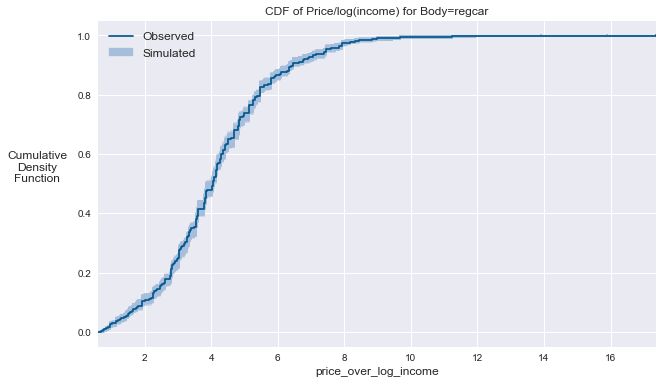

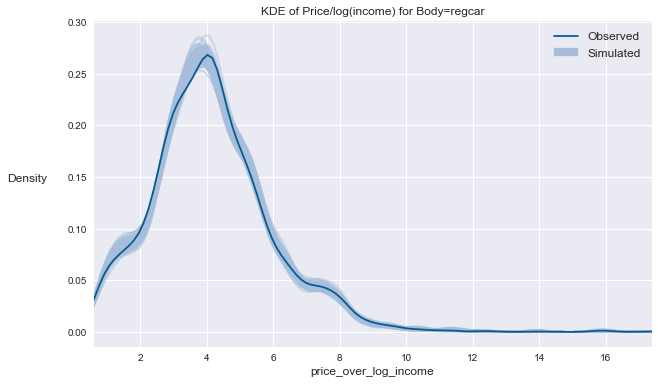

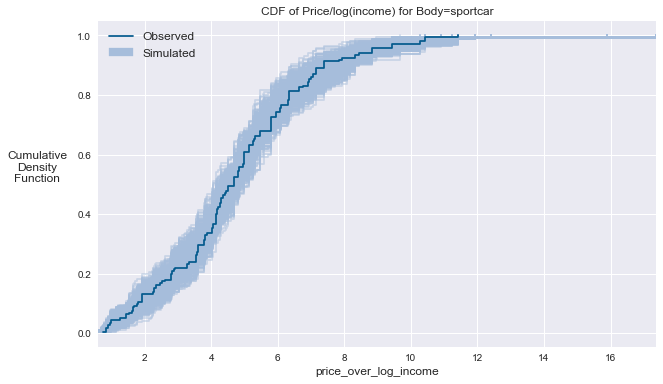

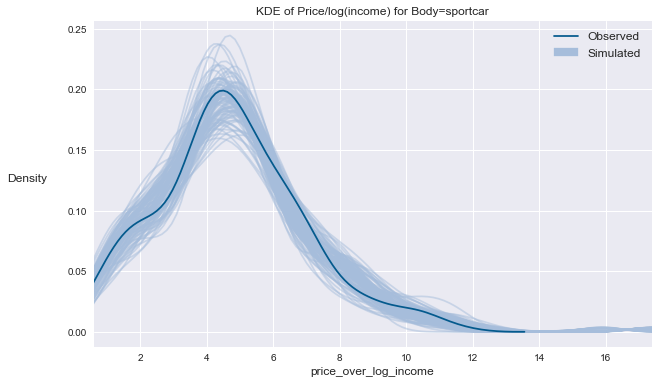

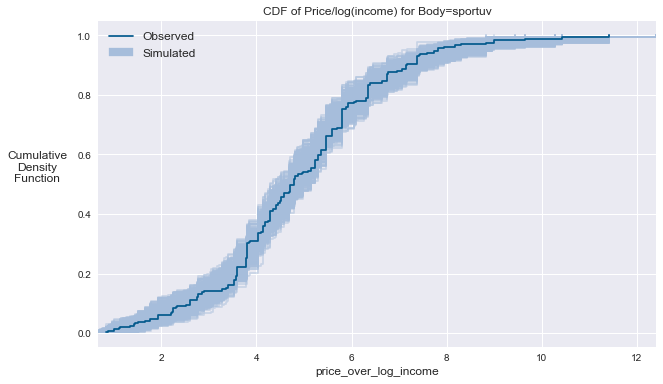

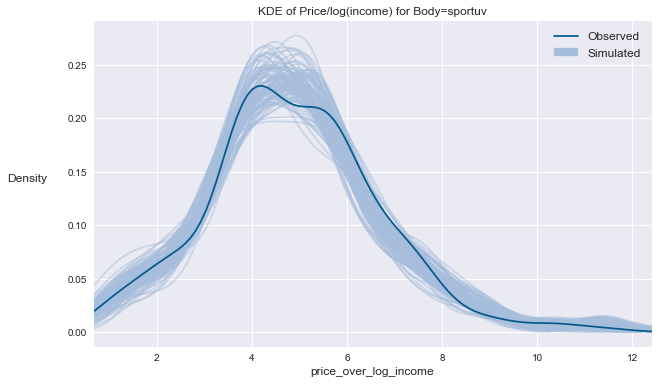

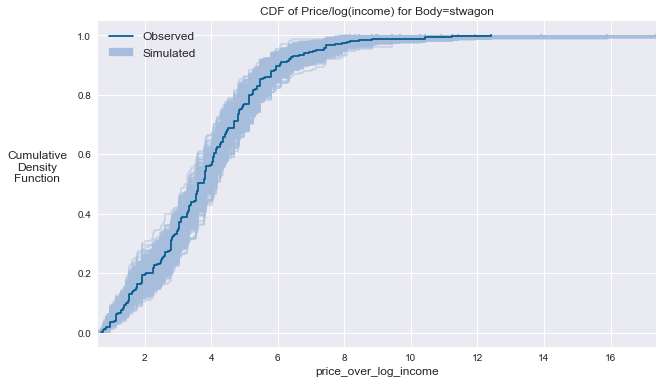

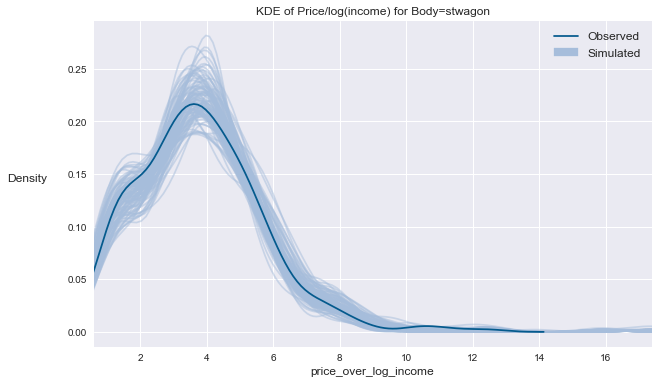

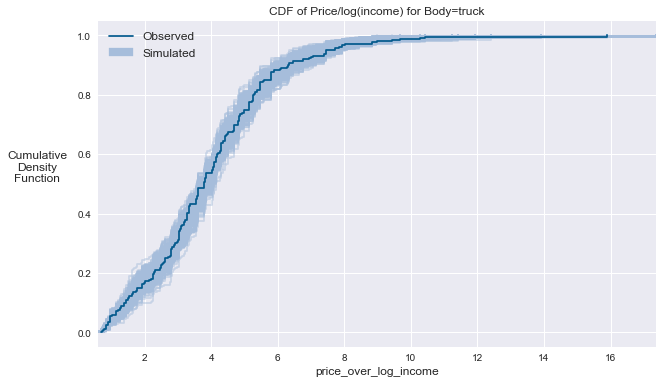

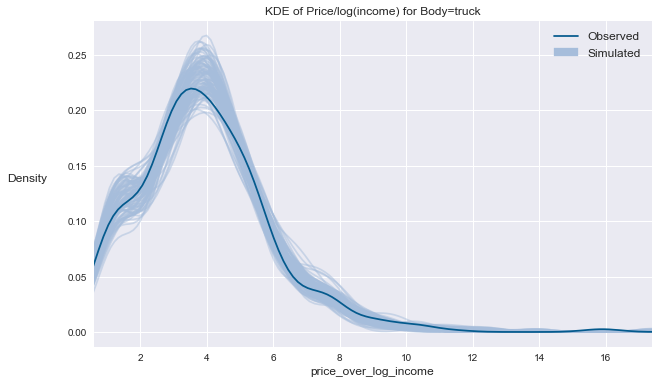

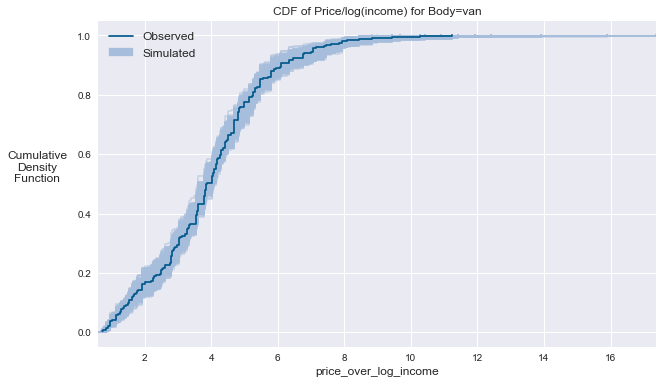

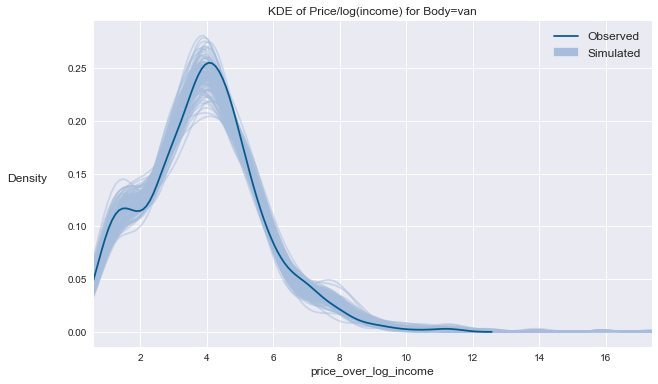

In [7]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated',
                                  title=current_title.format(body),
                                  figsize=(10, 6))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated',
                                  title=title_2.format(body),
                                  figsize=(10, 6))
    

From above, we see that we still have "mild" problems with the price variable. I'll move on though because there isn't much time.

# Key Takeaways

Accounting for systematic heterogeneity improved the model fit more than accounting for unobserved heterogeneity.

Accounting for sytematic heterogeneity <i>may</i> have improved the model fit on substantive features more than accounting for unobserved heterogeneity.

